# `H2MM_C` Displaying Optimization Progress

Let's get our obligitory imports in order, and we'll load the 3 detector data as well.

In [1]:
import os
import numpy as np
from matplotlib import pyplot as plt

import H2MM_C as hm


# load the data
def load_txtdata(filename):
    color = list()
    times = list()
    with open(filename,'r') as f:
        for i, line in enumerate(f):
            if i % 2 == 0:
                times.append(np.array([int(x) for x in line.split()],dtype=np.int64))
            else:
                color.append(np.array([int(x) for x in line.split()],dtype=np.uint8))
    return color, times

color3, times3 = load_txtdata('sample_data_3det.txt')

## Customizing Display of Optmization progression

You've probably seen that whenever `hm.EM_H2MM_C()` is run, you see the number of iterations currently computed gets displayed. This behavior can be modified however with the `print_func` keyword argument. This lets us choose how much/what information gets displayed! See the list of options below:


### Basic `print_func` options

- `'iter'` Prints only the iteration number- compact way to still track optimization progress in Jupyter Notebook
- `'all'` prints a representation of the whole model to be optimized in the next iteration (this will be very verbose).
- `'diff'` Print the difference between the previous and current model logliklihoods and the current loglikelihood.
- `'diff_time'` Same as `'diff'` but with additional information about how long the current iteration took, and the total time taken. These times however are not very accurate, because they use an inaccurate, but fast clock function.
- `'comp'` Print the old and current loglikelihoods
- `'comp_time'` Like `'diff_time'` but for `'comp'`
- `None` Suppresses all printing of iteration information.

In [2]:
model_3d3c = hm.EM_H2MM_C(hm.factory_h2mm_model(3,3), color3,  times3, print_func='diff')

The model converged after 198 iterations                       


### Changing frequence of Display updates with `print_freq`

`print_freq` is used to specify how frequently the display updates, by passing an *integer* value into `print_freq`, then the display will only update after that many iterations.

Update the display every 10 iterations:

In [3]:
model_3d3c = hm.EM_H2MM_C(hm.factory_h2mm_model(3,3), color3,  times3, print_func='diff', print_freq=10)

The model converged after 201 iterations                       


## Customized display using your own function

If you want to customize the display, you can define  your own printing function.

The function should have the following general signature:

`print_func(niter:int, new_model:h2mm_model, current_model:h2mm_model, old_model:h2mm_model, iter_time:int, total_time:float)->str`

> **NOTE**
>
> It is not necessary, but recommended to keep these variable names in the function declaration.

where:
- `niter` is the number of iterations
- `new_model` is a `h2mm_model` object that represents the next model to be optimized (**before** checking for out of bounds values) note that its `.loglik` will be irrelevant because it has not been calculated yet.
- `current_model` is a `h2mm_model` object that represents the model whose `.loglik` was just calculated
- `old_model` is a `h2mm_model` object that represents the model from the previous iteration.
- `iter_time` is a float which is the time in seconds based on the **inaccurate C clock** that it took to calculate the latest iteration
- `total_time` is a float which is the time in seconds based on the **inaccurate C clock** that the full optimization has taken

The output of `print_func` is converted to a string (`str()`) and displayed, unless `print_func` returns `None`, in which case nothing is printed (unless `print_func` internally calls its own print method)

So below is an example of a custom print function:

In [4]:
def silly_print(niter, new, current, old, titer, time):
    return (f"We haven't finished after {niter} iterations " 
           f"with {new.loglik - current.loglik} improvement "
           f"in loglik after {time} (inaccurate) seconds")

In [5]:
hm.EM_H2MM_C(hm.factory_h2mm_model(3,3), color3, times3, print_func=silly_print, print_freq=10)

The model converged after 198 iterations                                                                                   


nstate: 3, ndet: 3, nphot: 436084, niter: 198, loglik: -409379.14701993956 converged state: 0x27
prior:
0.2599161087080881, 0.49437683694695067, 0.2457070543449613
trans:
0.9999762009962716, 2.1091569337996854e-05, 2.7074343903649633e-06
8.392846121801916e-06, 0.9999812080448961, 1.0399108982083962e-05
6.290283042355416e-06, 4.466216582383375e-05, 0.9999490475511338
obs:
0.14570423954876852, 0.2934431830052035, 0.560852577446028
0.4417395147706429, 0.0876310597860471, 0.4706294254433099
0.8414287880015665, 0.07852868417810849, 0.08004252782032498

### Passing additional args to `print_func` with `print_args`

The true signature of print_args is 

`print_func(niter:int, new_model:h2mm_model, current_model:h2mm_model, old_model:h2mm_model, t_iter:int, t_total:float, *print_args, **print_kwargs)->str`

`EM_H2MM_C` has two keyword arguments, `print_args` and `print_kwargs`, only used when `print_func` is a callable, which are passed to `print_func` as
its args and kwargs. Note that in both cases, a value of `None` is converted into an empty tuple/dict respectively. Further, if a non-tuple is passed
to `print_args` it is treated as a single argument.)

In [6]:
def silly_print_arg_kwarg(niter, new, current, old, titer, time, *args, modulus=None):
    return f"niter={niter} args={args}, modulus={modulus}"

In [7]:
hm.EM_H2MM_C(hm.factory_h2mm_model(3,3), color3, times3, 
             print_func=silly_print_arg_kwarg, print_args="I'm very silly", print_kwargs=dict(modulus=1))

The model converged after 198 iterations     


nstate: 3, ndet: 3, nphot: 436084, niter: 198, loglik: -409379.14701993956 converged state: 0x27
prior:
0.2599161087080877, 0.4943768369469518, 0.24570705434496054
trans:
0.9999762009962716, 2.109156933799686e-05, 2.707434390364933e-06
8.392846121801852e-06, 0.9999812080448961, 1.0399108982083884e-05
6.29028304235531e-06, 4.4662165823833885e-05, 0.9999490475511338
obs:
0.1457042395487681, 0.2934431830052031, 0.5608525774460288
0.44173951477064244, 0.08763105978604725, 0.4706294254433104
0.8414287880015672, 0.07852868417810839, 0.08004252782032449

## Advanced options: Formatter

By default, optimization progress is printed to `sys.stdout`, and each update over-writes the previous update.
This is done using the `print_formatter`.

### Keeping display of each iteration

The default `print_formatter` has a single keyword argument: `keep`.
We can set this using the `print_fmt_kwargs` keyword argument in `EM_H2MM_C`,
if it is set to `True`, then the text of each new iteration will be displayed on a new line.

In [8]:
model_3d3c = hm.EM_H2MM_C(hm.factory_h2mm_model(3,3), color3,  times3, print_func='diff', print_fmt_kwargs=dict(keep=True))

Iteration:    0, loglik:-4.387899e+05, improvement:   inf
Iteration:    1, loglik:-4.203991e+05, improvement:1.839076e+04
Iteration:    2, loglik:-4.172495e+05, improvement:3.149621e+03
Iteration:    3, loglik:-4.168160e+05, improvement:4.334909e+02
Iteration:    4, loglik:-4.166697e+05, improvement:1.463433e+02
Iteration:    5, loglik:-4.165714e+05, improvement:9.831467e+01
Iteration:    6, loglik:-4.164868e+05, improvement:8.460410e+01
Iteration:    7, loglik:-4.164030e+05, improvement:8.370726e+01
Iteration:    8, loglik:-4.163116e+05, improvement:9.142352e+01
Iteration:    9, loglik:-4.162055e+05, improvement:1.061152e+02
Iteration:   10, loglik:-4.160785e+05, improvement:1.269588e+02
Iteration:   11, loglik:-4.159256e+05, improvement:1.529380e+02
Iteration:   12, loglik:-4.157447e+05, improvement:1.808611e+02
Iteration:   13, loglik:-4.155401e+05, improvement:2.046643e+02
Iteration:   14, loglik:-4.153189e+05, improvement:2.211944e+02
Iteration:   15, loglik:-4.150866e+05, improve

### Changing output stream with `print_stream`

The `print_formatter` can be instructed to direct the output to another stream, 
such as `sys.stderr` by specifying the `print_stream` keyword argument:

In [9]:
import sys
model_3d3c = hm.EM_H2MM_C(hm.factory_h2mm_model(3,3), color3,  times3, print_func='diff', print_stream=sys.stderr)

The model converged after 198 iterations                       


### Whats actually happeing

Now that simple options have been described, let's go through what actually is happeing.

Before an optimization begins, `EM_H2MM_C` creates a *formatter* object.
These are typically a subclass of `Printer`, the default being `StdPrinter`.
It does so by calling `print_formatter(print_stream, *print_fmt_args, **print_fmt_kwargs)`

> **Note**
>
> If `print_formatter` is `None`, then `print_formatter` will be the default
> formater specified by `optimization_limits.formatter`.
>
> If `print_stream` is `None`, it will be the default specified by
> *calling* `optmiziation_limits.outstream()`, this means that
> `optmiziation_limits.outstream` should be a callable that takes no
> arguments. This allows for a "factory" function to be creates so that
> the stream can be dynamically assigned.

Then optimization begins.

Upon the completion of an iteration of optimization, `EM_H2MM_C` first checks
if the iteration should be updated based on `print_freq`.

If it is time to update the display, then `EM_H2MM_C` calls `print_func` with the
cooresponding arguments, and hands the output as the single argument to
`formatter.update`. The total call look like:
`formatter.update(print_func(niter, new, current, old, iter_time, total_time, *print_args, **print_kwargs))`

At the end of the optimization `formatter.close()` is called, to ensure any finalization should be conducted.

The default `StdPrinter` has `__init__` signature of `(buffer, keep=False)`. From this you can see how
specifying `print_stream=sys.stderr` and `print_fmt_kwargs=dict(keep=False)` changes where the output is
printed and how it is printed respectively.

The `update` method takes the one argument, formats it according to `keep` and then
sends the formatted output to `print_stream.write(text)`, and the
calls `print_stream.flush()` to ensure the output is actually displayed.

#### IPyPrinter

Out of the box, `H2MM_C` comes with one other `Printer` class: `IPyPrinter`.
This class requires [IPython](https://ipython.org/) to be installed, if it is not,
then this class will not exist.

`IPyPrinter` is initiallized with the following signature: `(handle, keep=False)`
Where `handle` is a [IPython.display.DisplayHandle](https://ipython.readthedocs.io/en/8.26.0/api/generated/IPython.display.html)
So the default `sys.stdout` will not work for the `print_stream` argument.
Instead, you will have to generate a `DisplayHandle` to use `IPyPrinter`

Below see a simple call using `IPyPrinter`.

In [10]:
from IPython.display import DisplayHandle, clear_output

In [11]:
model_3d3c = hm.EM_H2MM_C(hm.factory_h2mm_model(3,3), color3,  times3, print_func='all', print_formatter=hm.IPyPrinter, print_stream=DisplayHandle())

The model converged after 198 iterations

Since it is awkward to create a `DisplayHandle` each time, if you plan to use `IPyPrinter`, I would suggest
setting `optimization_limits.formatter=IPyPrinter` and `optimization_limits.outstream=lambda:DisplayHandle()`
at the beginning of your code instead.

In [12]:
hm.optimization_limits.formatter = hm.IPyPrinter
hm.optimization_limits.outstream = lambda:DisplayHandle()

In [13]:
model_3d3c = hm.EM_H2MM_C(hm.factory_h2mm_model(3,3), color3,  times3, print_func='all', print_fmt_kwargs=dict(keep=True))

nstate: 3, ndet: 3, nphot: 436084, niter: 0, loglik: -438789.88126171875 converged state: 0x2
prior:
0.3333333333333333, 0.3333333333333333, 0.3333333333333333
trans:
0.9999800000000001, 9.999999999999999e-06, 9.999999999999999e-06
9.999999999999999e-06, 0.9999800000000001, 9.999999999999999e-06
9.999999999999997e-06, 9.999999999999997e-06, 0.99998
obs:
0.2, 0.6, 0.2
0.3333333333333333, 0.3333333333333333, 0.3333333333333333
0.42857142857142855, 0.14285714285714285, 0.42857142857142855

Iteration time:0.117147, Total:0.117147
nstate: 3, ndet: 3, nphot: 436084, niter: 1, loglik: -420399.1249372309 converged state: 0x3
prior:
0.1117208707845065, 0.2311783028752123, 0.6571008263402811
trans:
0.9999331696914695, 2.1507726405781882e-05, 4.532258212485634e-05
4.90099423170154e-06, 0.9999761060427823, 1.899296298592765e-05
2.3715976119226347e-06, 4.449513692035169e-06, 0.9999931788886961
obs:
0.1675383924040133, 0.5067016197975466, 0.3257599877984402
0.21132635485941328, 0.30405173296135757, 

What is the advantage of `IPyPrinter`?

Because it uses a DisplayHandle, it can fully clear the output each iteration, while `StdPrinter` 

relies on `\r` characters to overwrite the previous output, which can only overwrite the last line.

So if you plan to use `print_func='all'`, then `IPyPrinter` is recomended.

On the other hand, using `DisplayHandle` means that the `IPyPrinter` is slightly slower.

### Custom Printers

`H2MM_C` does not strictly enforce any typing on `print_formatter` objects, 
operating on the principle of [Duck Typing](https://en.wikipedia.org/wiki/Duck_typing)

All that is required is that calling
`print_formatter(print_stream, *print_args, **print_kwargs)` will create an object
that has `.update` and `.close` methods that take 1 and 0 arguments respectively,
with the `.update` method accepting whatever the output of `print_func` is.

However, `H2MM_C` provides `Printer` as an abstract base class, that is recomended as the
parent class of any `print_formatter`.

Indeed, both `StdPrinter` and `IPyPrinter` are subclasses of `Printer`

Below is the code for `IPyPlot`, which displays a plot each iteration

In [14]:
from itertools import product, chain

In [15]:
class IPyPlot(hm.Printer):
    """
    Class for plotting optimization progress on matplotlib axes.
    
    Parameters
    ----------
    
    stream: DiplayHandle
        DisplayHandle for where plots will be displayed
    nrow: int, optional
        number of rows of plots in output, the default is 1
    ncol: int, optional
        number of columns of plots in output, the default is 1
    xlim: tuple[tuple[tuple[int|float|str, int|float|str],...],...]
        nrow x ncol x 2 nested tuples, identifying min and max values
        for x axis of given [row][col] plot. If 'min' or 'max', take
        said values in arrays. Defautl is for 1x1 'min', 'max' values
    ylim: tuple[tuple[tuple[int|float|str, int|float|str],...],...]
        nrow x ncol x 2 nested tuples, identifying min and max values
        for y axis of given [row][col] plot. If 'min' or 'max', take
        said values in arrays. Defautl is for 1x1 'min', 'max' values
    plot_kwargs: dict, optional
        dictionary of keword argumetns given to ax.plot on first iteration
        Default is empty dictionary.
    **kwargs: dict
        kwargs handed to plt.subplots when creating initial figure and plots.
    """
    __slots__ = ('stream', 'fig', 'ax', 'data', 'lines', 'xlim', 'ylim', 'plot_kwargs')
    def __init__(self, stream, nrow=1, ncol=1, 
                 xlim=((('min', 'max'),),), ylim=((('min', 'max'),),),
                 plot_kwargs=None, **kwargs):
        if len(xlim) != nrow or len(ylim) != nrow:
            raise ValueError("xlim and ylim must be nrow x ncol array")
        if any(len(x) != ncol or len(y) != ncol for x, y in zip(xlim, ylim)):
            raise ValueError("xlim and ylim must be nrow x ncol x 2 array")
        if any(len(x) != 2 or len(y) != 2 for x, y in chain.from_iterable(zip(xx,yy) for xx, yy in zip(xlim, ylim))):
            raise ValueError("xlim and ylim must be nrow x ncol x 2 array")
        self.stream = stream
        self.fig, ax = plt.subplots(nrow, ncol, **kwargs)
        self.ax = np.atleast_2d(ax)
        self.data = False
        self.stream.display(self.fig)
        self.xlim = xlim
        self.ylim = ylim
        self.plot_kwargs = plot_kwargs if plot_kwargs is not None else dict()

    def update(self, data):
        """
        Update plot with new data points

        Parameters
        ----------
        data : list[list[np.ndarray]]
            An array-like nrow x ncol object, with each pair of elements
            being an x-y value pair to plot.

        Returns
        -------
        None.

        """
        if isinstance(data, str):
            return
        if self.data is False:
            self.data = np.empty(self.ax.shape, dtype=np.object_)
            self.lines = np.empty(self.ax.shape, dtype=np.object_)
            for i, j in product(range(self.ax.shape[0]), range(self.ax.shape[1])):
                self.data[i,j] = data[i][j][np.newaxis]
                self.lines[i,j] = self.ax[i,j].plot(*self.data[i,j].T, **self.plot_kwargs)
        else:
            for i, j in product(range(self.ax.shape[0]), range(self.ax.shape[1])):
                self.data[i,j] = np.concatenate([self.data[i,j], data[i][j][np.newaxis]])
                for k, line in enumerate(self.lines[i,j]):
                    line.set_xdata(self.data[i,j][:,2*k])
                    line.set_ydata(self.data[i,j][:,2*k+1])
        for i, j in product(range(self.ax.shape[0]), range(self.ax.shape[1])):
            xmin, xmax = self.xlim[i][j]
            if xmin == 'min':
                xmin = np.min(self.data[i,j][:,::2])
            if xmax == 'max':
                xmax = np.max(self.data[i,j][:,::2])
            ymin, ymax = self.ylim[i][j]
            if ymin == 'min':
                ymin = np.min(self.data[i,j][:,1::2])
            if ymax == 'max':
                ymax = np.max(self.data[i,j][:,1::2])
            if xmin == xmax:
                xmin -= 1.0
                xmax += 1.0
            if ymin == ymax:
                ymin -= 1.0
                ymax += 1.0
            self.ax[i,j].set_xlim([xmin, xmax])
            self.ax[i,j].set_ylim([ymin, ymax])
        self.stream.update(self.fig)

    def close(self):
        """
        Clear the display handle.

        Returns
        -------
        None.

        """
        clear_output()
        
def plot_bic(niter, new, current, old, iter_time, total_time):
    """Printing function for IPyPlot, plots BIC in single plot"""
    return [[np.array([niter, current.bic])]]

def plot_obs(niter, new, current, old, iter_time, total_time, dx=0, dy=1):
    return [[np.array([[current.obs[i,dx], current.obs[i,dy]] for i in range(current.nstate)]).reshape(-1)]]

def plot_obs_bic(niter, new, current, old, iter_time, total_time, dx=0, dy=1):
    return [[np.array([niter, current.bic]), np.array([[current.obs[i,dx], current.obs[i,dy]] for i in range(current.nstate)]).reshape(-1)]]

nstate: 2, ndet: 3, nphot: 436084, niter: 84, loglik: -416808.4605439942 converged state: 0x27
prior:
0.284200554143071, 0.715799445856929
trans:
0.9999702727150822, 2.9727284917793736e-05
1.3614951882954524e-05, 0.999986385048117
obs:
0.1558440237836963, 0.26498198690992186, 0.5791739893063819
0.5300104078320693, 0.08194015753820581, 0.388049434629725

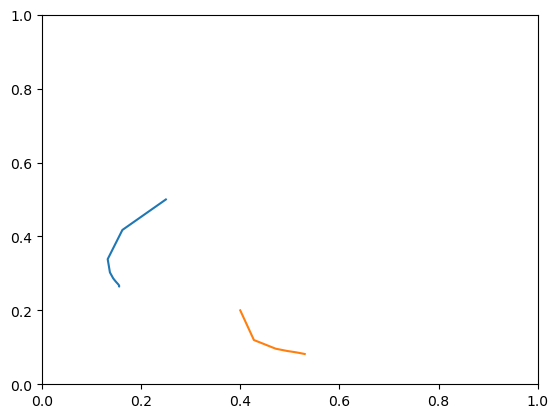

In [16]:
model = hm.factory_h2mm_model(2,3)
model.optimize(color3, times3, print_formatter=IPyPlot, 
               print_stream=DisplayHandle(), print_func=plot_obs, print_fmt_kwargs=dict(xlim=(((0,1),),), ylim=(((0,1),),)))